In [1]:
# first make sure the input data are good 
import numpy as np 
import os 
import sys 
from scipy.stats import zscore

os.chdir('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning')
fold_path = 'allData/prognosis/pretreatment_response'
clinical_data = np.load(fold_path + '/baseline_clinical_data.npy', allow_pickle=True)
MMDT_score = np.load(fold_path + '/MMDT_score.npy', allow_pickle=True)[..., np.newaxis]



In [10]:

def replace_nan_with_mean(data):
    input = data.copy()
    for i in range(input.shape[1]):
        col = input[:, i]
        col = np.array(col, dtype=float)
        mean_value = np.nanmean(col)
        col[np.isnan(col)] = mean_value
        input[:, i] = col
    return input
def impute_nan_data(data):
    input = data.copy()
    from sklearn.experimental import enable_iterative_imputer
    # Now you can import IterativeImputer
    from sklearn.impute import IterativeImputer


    # Create an instance of IterativeImputer
    imputer = IterativeImputer()

    # Fit the imputer on the clinical_data ndarray
    imputer.fit(input)

    # Transform the clinical_data ndarray by imputing the NaN values
    imputed_data = imputer.transform(input)
    return imputed_data

mean_data = replace_nan_with_mean(clinical_data)
imputed_data = impute_nan_data(clinical_data)

z_imputed_data = zscore(imputed_data, axis=0)

# add MMDT data

demographic_data = np.load(fold_path + '/demografic_data.npy', allow_pickle=True)
demographic_data = demographic_data.astype(float)
demographic_data = impute_nan_data(demographic_data)
demographic_data = zscore(demographic_data, axis=0)

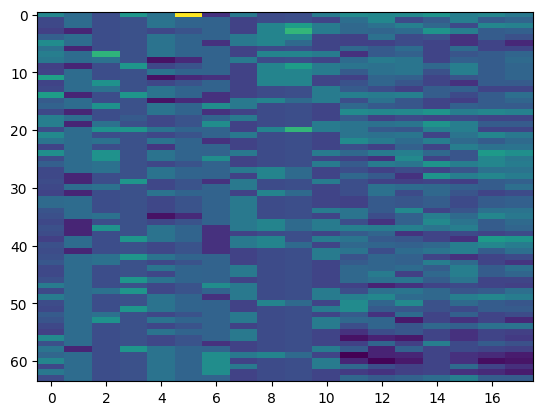

In [14]:
demo_cli_merge_data = np.concatenate((demographic_data, z_imputed_data), axis=1)
import matplotlib.pyplot as plt
plt.imshow(demo_cli_merge_data, aspect='auto')
np.save(fold_path + '/nor_demo_cli_merge_data.npy', demo_cli_merge_data)

In [25]:
combine = list(zip(demo_cli_merge_data, demo_cli_merge_data, demo_cli_merge_data))

import random
random.shuffle(combine)

a, b, c = zip(*combine)
print(a[0])
print(b[0])
print(c[0])


[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]
[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]
[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]


In [11]:


fusion_data = np.concatenate((z_imputed_data, MMDT_score), axis=1)
print(fusion_data.shape)
np.save(fold_path + '/fusion_data.npy', fusion_data)
X_train = fusion_data
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

(64, 8)


In [12]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

X_train = fusion_data
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

# 定义模型
model = CatBoostClassifier(verbose=0)

# 参数网格
param_grid = {
    'learning_rate': [1e-6],
    'depth': [4],
    'l2_leaf_reg': [5],
    'iterations': [100],
    'border_count': [32],


}

# 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# 最佳参数和性能
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'border_count': 32, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 1e-06}
Best score: 0.7813852813852814


In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

X_train = fusion_data
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

# 定义模型
model = XGBClassifier(scale_pos_weight=61*1e5)

# 参数网格
# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth': [4],  # Depth of trees. Increasing this value will make the model more complex and more likely to overfit.
    'learning_rate': [0.01],  # Step size shrinkage used to prevent overfitting. Range is [0,1]
    'scale_pos_weight': [1e2],  # A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
}

# 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, Y_train)

# 最佳参数和性能
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50, 'scale_pos_weight': 100.0}
Best score: 1.0


In [30]:
demographic_data = np.load(fold_path + '/demografic_data.npy', allow_pickle=True)
demographic_data = demographic_data.astype(float)
demographic_data = np.nan_to_num(demographic_data, 0)
demographic_data = zscore(demographic_data, axis=0)
print(demographic_data)

[[ 1.54893332  0.52915026 -0.60535015  2.1665957   0.81749636  6.79962494
  -1.51102763  1.03175391 -0.67419986 -0.5400228   1.13389342]
 [-0.77874548  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171 ]
 [-0.77874548  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337  1.4832397   2.50951771  1.13389342]
 [-1.05259005 -1.88982237 -0.60535015 -0.42521972 -0.80064077 -0.40961596
   0.1855648  -0.96922337  1.4832397   3.52603121  1.13389342]
 [ 0.04278821  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648   1.03175391  1.4832397   1.4930042  -0.8819171 ]
 [ 1.82277789  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
  -1.51102763  1.03175391  1.4832397   0.4764907  -0.8819171 ]
 [ 0.72739963 -1.88982237 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171 ]
 [ 1.27508876  0.52915026  3.40248531 -0.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_validate

X_train = fusion_data
models = {
    'CatBoost': CatBoostClassifier(verbose=0),
    'XGBoost': XGBClassifier(scale_pos_weight=61 * 1e5),
    'RandomForest': RandomForestClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'Support Vector': SVC(),
    'NearestNeighbor': KNeighborsClassifier(),
    'Perceptron': Perceptron()
}

results = {}

for model_name, model in models.items():
    # Define the scorers you want to use
    scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score),
               'sensitivity': make_scorer(recall_score)}
    
    # Perform 5-fold cross-validation and get the results
    cv_results = cross_validate(model, X_train, Y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Calculate mean scores
    mean_accuracy = cv_results['test_balanced_accuracy'].mean()
    mean_sensitivity = cv_results['test_sensitivity'].mean()
    
    # Store the results
    results[model_name] = {'bAcc': mean_accuracy, 'Sensitivity': mean_sensitivity}

results


{'CatBoost': {'bAcc': 0.5599999999999999, 'Sensitivity': 0.2},
 'XGBoost': {'bAcc': 0.62, 'Sensitivity': 0.6},
 'RandomForest': {'bAcc': 0.55, 'Sensitivity': 0.2},
 'DecisionTree': {'bAcc': 0.4699999999999999, 'Sensitivity': 0.2},
 'Support Vector': {'bAcc': 0.5, 'Sensitivity': 0.0},
 'NearestNeighbor': {'bAcc': 0.5, 'Sensitivity': 0.0},
 'Perceptron': {'bAcc': 0.5433333333333333, 'Sensitivity': 0.4666666666666666}}

In [41]:
Y_train

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])

In [1]:
import matplotlib.pyplot as plt
fusion_data[:,-1:]

last_fusion_data = fusion_data[:,-1:].copy()
pos_las = last_fusion_data[Y_train == 1]
neg_las = last_fusion_data[Y_train == 0]
plt.hist(pos_las, bins=20, alpha=0.5, label='Positive')

plt.figure()
plt.hist(neg_las, bins=20, alpha=0.5, label='Negative')

NameError: name 'fusion_data' is not defined